# How to add multi-turn conversation in a multi-agent application

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [Node](/langgraphjs/concepts/low_level/#nodes)
    - [Command](/langgraphjs/concepts/low_level/#command)
    - [Multi-agent systems](/langgraphjs/concepts/multi_agent)
    - [Human-in-the-loop](/langgraphjs/concepts/human_in_the_loop)


In this how-to guide, we’ll build an application that allows an end-user to engage in a *multi-turn conversation* with one or more agents. We'll create a node that uses an [`interrupt`](/langgraphjs/reference/functions/langgraph.interrupt-1.html) to collect user input and routes back to the **active** agent.

The agents will be implemented as nodes in a graph that executes agent steps and determines the next action:  

1. **Wait for user input** to continue the conversation, or  
2. **Route to another agent** (or back to itself, such as in a loop) via a [**handoff**](/langgraphjs/concepts/multi_agent/#handoffs).

```typescript
function human(state: typeof MessagesAnnotation.State): Command {
  const userInput: string = interrupt("Ready for user input.");

  // Determine the active agent
  const activeAgent = ...; 

  return new Command({
    update: {
      messages: [{
        role: "human",
        content: userInput,
      }]
    },
    goto: activeAgent,
  });
}

function agent(state: typeof MessagesAnnotation.State): Command {
  // The condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
  const goto = getNextAgent(...); // 'agent' / 'anotherAgent'

  if (goto) {
    return new Command({
      goto,
      update: { myStateKey: "myStateValue" }
    });
  } else {
    return new Command({
      goto: "human"
    });
  }
}
```


## Setup

First, let's install the required packages

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__...";
process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_TRACING_V2 = "true";
process.env.LANGCHAIN_PROJECT = "Time Travel: LangGraphJS";

Time Travel: LangGraphJS


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Travel Recommendations Example

In this example, we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 3 agents:

* `travelAdvisor`: can help with general travel destination recommendations. Can ask `sightseeingAdvisor` and `hotelAdvisor` for help.
* `sightseeingAdvisor`: can help with sightseeing recommendations. Can ask `travelAdvisor` and `hotelAdvisor` for help.
* `hotelAdvisor`: can help with hotel recommendations. Can ask `sightseeingAdvisor` and `hotelAdvisor` for help.

This is a fully-connected network - every agent can talk to any other agent. 

To implement the handoffs between the agents we'll be using LLMs with structured output. Each agent's LLM will return an output with both its text response (`response`) as well as which agent to route to next (`goto`). If the agent has enough information to respond to the user, the `goto` will be set to `human` to route back and collect information from a human.

Now, let's define our agent nodes and graph!

In [2]:
import { z } from "zod";
import { ChatOpenAI } from "@langchain/openai";
import { BaseMessage } from "@langchain/core/messages";
import {
  MessagesAnnotation,
  StateGraph,
  START,
  Command,
  interrupt,
  MemorySaver
} from "@langchain/langgraph";

const model = new ChatOpenAI({ model: "gpt-4o" });


/**
 * Call LLM with structured output to get a natural language response as well as a target agent (node) to go to next.
 * @param messages list of messages to pass to the LLM
 * @param targetAgentNodes list of the node names of the target agents to navigate to
 */
function callLlm(messages: BaseMessage[], targetAgentNodes: string[]) {
  // define the schema for the structured output:
  // - model's text response (`response`)
  // - name of the node to go to next (or 'finish')
  const outputSchema = z.object({
    response: z.string().describe("A human readable response to the original question. Does not need to be a final response. Will be streamed back to the user."),
    goto: z.enum(["finish", ...targetAgentNodes]).describe("The next agent to call, or 'finish' if the user's query has been resolved. Must be one of the specified values."),
  })
  return model.withStructuredOutput(outputSchema, { name: "Response" }).invoke(messages)
}

async function travelAdvisor(
  state: typeof MessagesAnnotation.State
): Promise<Command> {
  const systemPrompt = 
      "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). " +
      "If you need specific sightseeing recommendations, ask 'sightseeingAdvisor' for help. " +
      "If you need hotel recommendations, ask 'hotelAdvisor' for help. " +
      "If you have enough information to respond to the user, return 'finish'. " +
      "Never mention other agents by name.";

  const messages = [{"role": "system", "content": systemPrompt}, ...state.messages] as BaseMessage[];
  const targetAgentNodes = ["sightseeingAdvisor", "hotelAdvisor"];
  const response = await callLlm(messages, targetAgentNodes);
  const aiMsg = {"role": "ai", "content": response.response, "name": "travelAdvisor"};
  
  let goto = response.goto;
  if (goto === "finish") {
      goto = "human";
  }

  return new Command({goto, update: { "messages": [aiMsg] } });
}

async function sightseeingAdvisor(
  state: typeof MessagesAnnotation.State
): Promise<Command> {
  const systemPrompt = 
      "You are a travel expert that can provide specific sightseeing recommendations for a given destination. " +
      "If you need general travel help, go to 'travelAdvisor' for help. " +
      "If you need hotel recommendations, go to 'hotelAdvisor' for help. " +
      "If you have enough information to respond to the user, return 'finish'. " +
      "Never mention other agents by name.";

  const messages = [{"role": "system", "content": systemPrompt}, ...state.messages] as BaseMessage[];
  const targetAgentNodes = ["travelAdvisor", "hotelAdvisor"];
  const response = await callLlm(messages, targetAgentNodes);
  const aiMsg = {"role": "ai", "content": response.response, "name": "sightseeingAdvisor"};
  
  let goto = response.goto;
  if (goto === "finish") {
      goto = "human";
  }

  return new Command({ goto, update: {"messages": [aiMsg] } });
}

async function hotelAdvisor(
  state: typeof MessagesAnnotation.State
): Promise<Command> {
  const systemPrompt = 
      "You are a travel expert that can provide hotel recommendations for a given destination. " +
      "If you need general travel help, ask 'travelAdvisor' for help. " +
      "If you need specific sightseeing recommendations, ask 'sightseeingAdvisor' for help. " +
      "If you have enough information to respond to the user, return 'finish'. " +
      "Never mention other agents by name.";

  const messages = [{"role": "system", "content": systemPrompt}, ...state.messages] as BaseMessage[];
  const targetAgentNodes = ["travelAdvisor", "sightseeingAdvisor"];
  const response = await callLlm(messages, targetAgentNodes);
  const aiMsg = {"role": "ai", "content": response.response, "name": "hotelAdvisor"};
  
  let goto = response.goto;
  if (goto === "finish") {
      goto = "human";
  }

  return new Command({ goto, update: {"messages": [aiMsg] } });
}

function humanNode(
  state: typeof MessagesAnnotation.State
): Command {
  const userInput: string = interrupt("Ready for user input.");

  let activeAgent: string | undefined = undefined;

  // Look up the active agent
  for (let i = state.messages.length - 1; i >= 0; i--) {
      if (state.messages[i].name) {
          activeAgent = state.messages[i].name;
          break;
      }
  }

  if (!activeAgent) {
      throw new Error("Could not determine the active agent.");
  }

  return new Command({
      goto: activeAgent,
      update: {
        "messages": [
            {
                "role": "human",
                "content": userInput,
            }
        ]
      }
  });
}

const builder = new StateGraph(MessagesAnnotation)
  .addNode("travelAdvisor", travelAdvisor, {
    ends: ["sightseeingAdvisor", "hotelAdvisor"]
  })
  .addNode("sightseeingAdvisor", sightseeingAdvisor, {
    ends: ["human", "travelAdvisor", "hotelAdvisor"]
  })
  .addNode("hotelAdvisor", hotelAdvisor, {
    ends: ["human", "travelAdvisor", "sightseeingAdvisor"]
  })
  // This adds a node to collect human input, which will route
  // back to the active agent.
  .addNode("human", humanNode, {
    ends: ["hotelAdvisor", "sightseeingAdvisor", "travelAdvisor", "human"]
  })
  // We'll always start with a general travel advisor.
  .addEdge(START, "travelAdvisor")

const checkpointer = new MemorySaver()
const graph = builder.compile({ checkpointer })

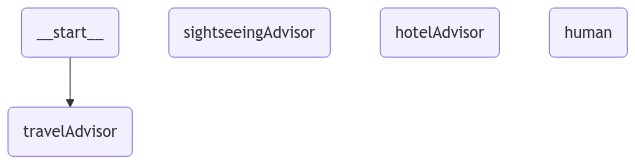

In [3]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

### Test multi-turn conversation

Let's test a multi turn conversation with this application.

In [4]:
import { Command } from "@langchain/langgraph";
import { v4 as uuidv4 } from "uuid";

const threadConfig = { configurable: { thread_id: uuidv4() }, streamMode: "values" as const };

const inputs = [
  // 1st round of conversation
  {
    messages: [
      { role: "user", content: "i wanna go somewhere warm in the caribbean" }
    ]
  },
  // Since we're using `interrupt`, we'll need to resume using the Command primitive.
  // 2nd round of conversation
  new Command({
    resume: "could you recommend a nice hotel in one of the areas and tell me which area it is."
  }),
  // Third round of conversation
  new Command({ resume: "could you recommend something to do near the hotel?" }),
]

let iter = 0;
for await (const userInput of inputs) {
  iter += 1;
  console.log(`\n--- Conversation Turn ${iter} ---\n`);
  console.log(`User: ${JSON.stringify(userInput)}\n`);

  for await (const update of await graph.stream(userInput, threadConfig)) {
    const lastMessage = update.messages ? update.messages[update.messages.length - 1] : undefined;
    if (lastMessage && lastMessage._getType() === "ai") {
      console.log(`${lastMessage.name}: ${lastMessage.content}`)
    }
  }
}



--- Conversation Turn 1 ---

User: {"messages":[{"role":"user","content":"i wanna go somewhere warm in the caribbean"}]}

travelAdvisor: The Caribbean is a fantastic choice for a warm getaway! Some popular destinations you might consider include Jamaica, the Dominican Republic, and the Bahamas. Each destination offers beautiful beaches, warm weather, and a plethora of activities to enjoy in a tropical setting. Aruba and Barbados are also great choices if you prefer lively beach towns with vibrant nightlife and cultural richness.

Would you like recommendations on sightseeing or places to stay in any of these Caribbean destinations?

--- Conversation Turn 2 ---

User: {"lg_name":"Command","lc_direct_tool_output":true,"resume":"could you recommend a nice hotel in one of the areas and tell me which area it is.","goto":[]}

travelAdvisor: The Caribbean is a fantastic choice for a warm getaway! Some popular destinations you might consider include Jamaica, the Dominican Republic, and the Ba